### Анализ сезонных колебаний цен на аренду квартир в Санкт-Петербурге

**Описание**:

В данном проекте мы анализируем цены на аренду квартир в Санкт-Петербурге, собранные с сайта Cian.ru.
Цель анализа — выявить влияние сезона, района и характеристик жилья на стоимость аренды.


In [ ]:
# установка необходимых библиотек (раскомментировать для установки)
# !pip install pandas numpy cianparser matplotlib seaborn wordcloud

# Загрузка данных

In [2]:
import os
import cianparser
import pandas as pd

def parse_cian_spb_min_records(min_records=150, deal_type='sale', rooms=(1, 2), save_dir='../data'):
    '''
    Функция для парсинга объявлений с Cian.ru
    '''
    # Инициализация парсера с нужным городом
    parser = cianparser.CianParser(location="Санкт-Петербург")
    all_data = []
    start_page = 1
    end_page = start_page
    
    # Цикл сбора данных, пока не достигнем нужного количества записей
    while len(all_data) < min_records:
        print(f"Парсим страницу {end_page}...")
        data = parser.get_flats(
            deal_type=deal_type,
            rooms=rooms,
            with_saving_csv=False,
            additional_settings={"start_page": end_page, "end_page": end_page}
        )
        if not data:
            print("Данных больше нет или возникла ошибка.")
            break
        all_data.extend(data)
        end_page += 1

    all_data = all_data[:min_records]

    # Сохранение в csv
    if all_data:
        df = pd.DataFrame(all_data)
        filename = 'cian_spb_data.csv'
        filepath = os.path.join(save_dir, filename)
        df.to_csv(filepath, index=False, encoding='utf-8-sig')
        print(f"Собрано {len(all_data)} записей. Данные сохранены в файл {filepath}")
    else:
        print("Не удалось получить данные.")

if __name__ == "__main__":
    parse_cian_spb_min_records(min_records=150, deal_type='sale', rooms=(1, 2), save_dir='../data')

Парсим страницу 1...

                              Preparing to collect information from pages..
The page from which the collection of information begins: 
 https://cian.ru/cat.php?engine_version=2&p=1&with_neighbors=0&region=2&deal_type=sale&offer_type=flat&room1=1&room2=1

 1 | 1 page with list: [=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>] 100% | Count of all parsed: 28. Progress ratio: 100 %. Average price: 56 018 946 rub

The collection of information from the pages with list of offers is completed
Total number of parsed offers: 28. 
Парсим страницу 2...

                              Preparing to collect information from pages..
The page from which the collection of information begins: 
 https://cian.ru/cat.php?engine_version=2&p=2&with_neighbors=0&region=2&deal_type=sale&offer_type=flat&room1=1&room2=1

 1 | 2 page with list: [=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>] 100% | Count of all parsed: 28. Progress ratio: 100 %. Average price: 129 661 110 

## Очистка данных и подготовка к анализу

In [4]:
import pandas as pd
import numpy as np

# Загрузка данных
df = pd.read_csv('../data/cian_spb_data.csv', encoding='utf-8')

# 1. Удаляем дубликаты
df = df.drop_duplicates()

# 2. Заменяем -1 и 0 в цене на NaN (0 - маловероятная цена для рынка)
df['price'] = df['price'].replace([-1, 0], np.nan)

# 3. Удаляем строки с пропусками в ключевых столбцах
key_columns = ['price', 'total_meters', 'rooms_count', 'district']
df = df.dropna(subset=key_columns)

# 4. Оставляем только нужные для анализа столбцы
columns_to_keep = ['price', 'total_meters', 'rooms_count', 'district', 'author_type']
df = df[columns_to_keep]

# 5. Приводим типы данных к нужным
df['rooms_count'] = df['rooms_count'].astype(int)
df['total_meters'] = df['total_meters'].astype(float)
df['price'] = df['price'].astype(float)

# Проверка итоговых данных
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 135 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         135 non-null    float64
 1   total_meters  135 non-null    float64
 2   rooms_count   135 non-null    int64  
 3   district      135 non-null    object 
 4   author_type   135 non-null    object 
dtypes: float64(2), int64(1), object(2)
memory usage: 6.3+ KB
None
              price  total_meters  rooms_count
count  1.350000e+02    135.000000   135.000000
mean   1.947049e+07     51.857185     1.474074
std    1.745998e+07     19.434507     0.501187
min    4.890000e+06     24.890000     1.000000
25%    9.990000e+06     38.900000     1.000000
50%    1.505608e+07     48.500000     1.000000
75%    2.335411e+07     57.900000     2.000000
max    1.392000e+08    168.600000     2.000000


## Анализ и визуализация

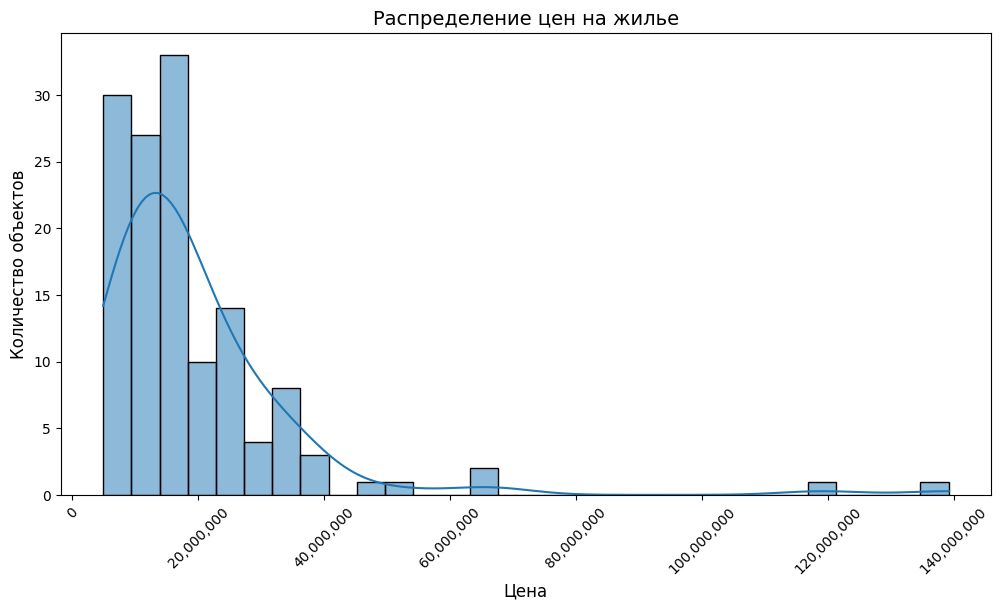

In [11]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# Гистограмма цен

# Визуализация 1: Распределение цен
plt.figure(figsize=(12, 6))
ax = sns.histplot(df['price'], bins=30, kde=True)
plt.title('Распределение цен на жилье', fontsize=14)
plt.xlabel('Цена', fontsize=12)
plt.ylabel('Количество объектов', fontsize=12)

# Форматирование оси X
def format_rub(x, pos):
    try:
        return f'{int(x):,}'.replace(',', ' ') + ' ₽'
    except:
        return x

ax.xaxis.set_major_formatter(FuncFormatter(format_rub))
plt.xticks(rotation=45)
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))  # Альтернативный способ
plt.show()

Видим ненормальное распределение данных с "хвостом" справа. Большая часть квартир находятся в ценовом диапазоне до 20 млн руб, при этом есть небольшой пик около значения в 120 млн руб.

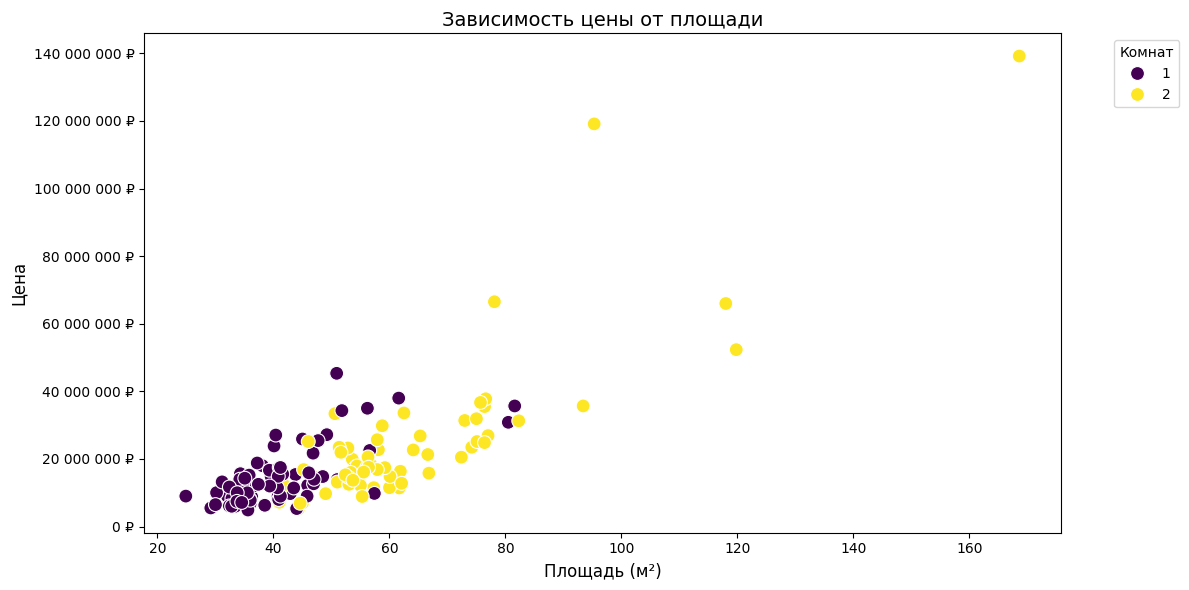

In [12]:
# Зависимость цены от площади и количества комнат

# Визуализация 2: Цена и Площадь
plt.figure(figsize=(12, 6))
ax = sns.scatterplot(
    x='total_meters',
    y='price',
    data=df,
    hue='rooms_count',
    palette='viridis',
    s=100
)
plt.title('Зависимость цены от площади', fontsize=14)
plt.xlabel('Площадь (м²)', fontsize=12)
plt.ylabel('Цена', fontsize=12)

# Форматирование оси Y
ax.yaxis.set_major_formatter(FuncFormatter(format_rub))
plt.legend(title='Комнат', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Цена напрямую зависит от площади, но также наблюдается и значительный разброс, вероятно из-за других факторов (район, этаж, инфраструктура...).

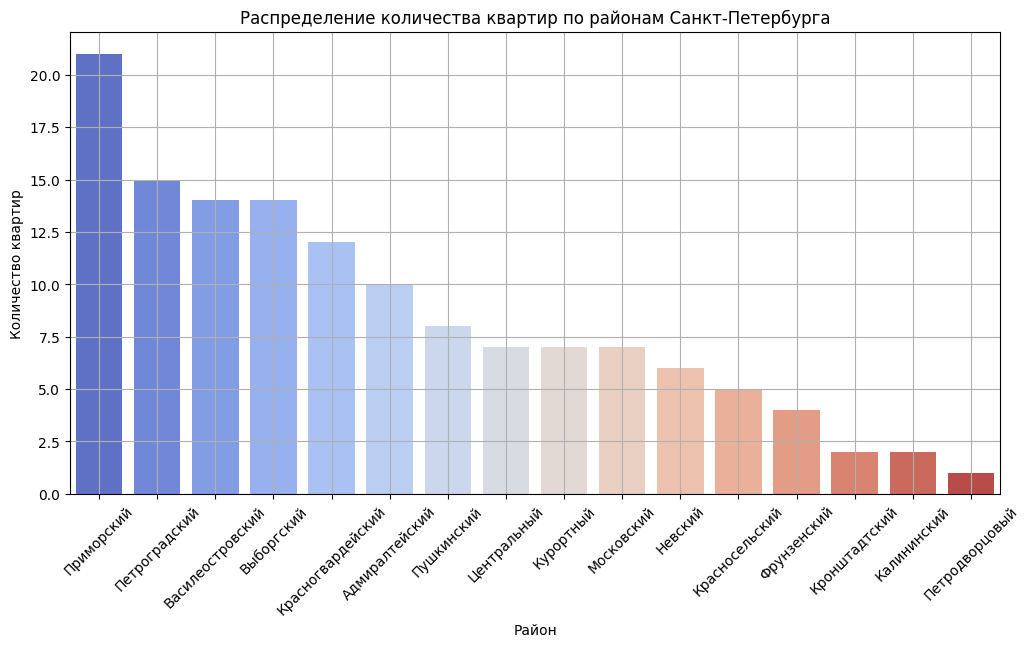

In [8]:
# Распределение количества квартир по районам

district_counts = df['district'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=district_counts.index, y=district_counts.values, palette='coolwarm', hue=district_counts.index)
plt.title('Распределение количества квартир по районам Санкт-Петербурга')
plt.xlabel('Район')
plt.ylabel('Количество квартир')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Видим, что самые популярные предложения о продаже квартир приходятся на Василеостровсикй, Приморский, Петроградский и Выборгский районы. Менее всего популярны Кировский, Калининский и Кронштадтский.

## Обсуждение

Итог: Исследование дает базовое понимание о некоторых характеристиках рынка жилой недвижимости Санкт-Петербурга, но требует расширения данных и дальнейшего более подробного анализа.
Что было сделано и что удалось?
Проведен анализ данных о недвижимости Санкт-Петербурга для выявления трендов, распределения цен и их зависимости от характеристик объектов (площадь, количество комнат, район). Выявлены ключевые закономерности.

Что не удалось и почему?
Не удалось построить карты районов с распределением цен и провести анализ зависимости цен от близости к станциям метро из-за отсутствия координат объектов и информации о расстоянии до метро.

Как улучшить исследование?
Собрать расширенные данные, то есть добавить координаты объектов, данные о расстоянии до метро, инфраструктуре района (школы, парки) и тд. Включить информацию о типе дома (новостройка, вторичка), ремонте, году постройки.

Использовать дополнительные методы анализа.

Полезность исследования и дальнейшие шаги
Для кого полезно:

Риелторы: Для анализа рыночных тенденций и формирования ценовых предложений.

Застройщики: Для выявления перспективных районов и планирования новых проектов.

Покупатели: Для сравнения цен и выбора оптимальных вариантов.

Дополнительные шаги:

Создать интерактивный дэшборд с возможностью фильтрации данных.

Интегрировать данные с открытыми источниками.